In [2]:
import os
os.chdir('../../')

In [4]:
from mobility_service_model import MobilityModel
from activity_scheduler import ActivityScheduler
from mode_choice_nhts import NhtsModeLogit
from two_stage_logit_hlc import TwoStageLogitHLC
from cs_handler import CS_Handler

import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from copy import deepcopy
import matplotlib.pyplot as plt

# Functions

In [5]:
def compair_prob(base_prob, new_prob, alts, groups=[1], prefix=''):
    if base_prob.shape[1] < len(alts): 
        base_prob = np.hstack((base_prob, np.zeros((base_prob.shape[0], len(alts)-base_prob.shape[1]))))
    for g in groups:
        print('\n{}Change of Probability Distribution, GroupID = {}:'.format(prefix, g))
        print('-'*80)
        print('{:15s} {:15s} {:15s} {:15s} {:15s}'.format('Mode', 'Base', 'New', 'New-Base', '(New-Base)/Base%'))
        for idx, alt in enumerate(alts.values()):
            print('{:15s} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.2%}'.format(alt, base_prob[g,idx], new_prob[g,idx], new_prob[g,idx]-base_prob[g,idx],
                                          (new_prob[g,idx]-base_prob[g,idx])/base_prob[g,idx]))
            
def nested_logit_experiment_individual(dissimilarity, groupID):
    nests_spec=[{'name': 'pt_like', 'alts':['share_bike', 'PT'], 'lambda':dissimilarity}]
    new_gnl_model.gnl_predict(nests_spec)
    alts = {0:'drive', 1:'cycle', 2:'walk', 3:'PT', 4:'bikeshare'}
    compair_prob(base_model.predicted_prob, new_mnl_model.predicted_prob, alts, groups=[groupID], prefix='For Logit model, ')
    compair_prob(base_model.predicted_prob, new_gnl_model.predicted_prob, alts, groups=[groupID], 
              prefix='For Nested Logit model, ')
    
def nested_logit_experiment_overall(dissimilarity):
    nests_spec=[{'name': 'pt_like', 'alts':['share_bike', 'PT'], 'lambda':dissimilarity},
                {'name': 'walk_like', 'alts':['share_bike','walk'], 'lambda': 0.7}
               ]
    new_gnl_model.gnl_predict(nests_spec)
    share_bike_prob_comes_from = np.zeros(4)
    for base_prob_row, gnl_prob_row in zip(base_model.predicted_prob, new_gnl_model.predicted_prob):
        share_bike_prob_comes_from += base_prob_row - gnl_prob_row[:4]
    share_bike_prob_comes_from  = share_bike_prob_comes_from / share_bike_prob_comes_from.sum()
    sorted_idx = (-share_bike_prob_comes_from).argsort()
    alts_list = np.asarray(['drive', 'cycle', 'walk', 'PT'])
    plt.figure(figsize=(12,8))
    plt.bar(alts_list[sorted_idx], share_bike_prob_comes_from[sorted_idx])
    for x, y in zip([0,1,2,3], share_bike_prob_comes_from[sorted_idx]):
        plt.text(x, y+0.01, '{:4.2%}'.format(y), ha='center', va='bottom',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Substituted Modes for Bikeshare',fontsize=25)
    plt.ylim([0,0.48])
    

# Prepare

In [6]:
model=MobilityModel('corktown', 'Detroit')
model.assign_activity_scheduler(ActivityScheduler(model=model))
model.assign_mode_choice_model(NhtsModeLogit(table_name='corktown', city_folder='Detroit'))

# create trips for base_sim persons
for person in model.pop.base_sim:
    model.activity_scheduler.sample_activity_schedules(person, model=model)
model.create_trips(model.pop.base_sim)

persons = model.pop.base_sim
all_trips=[]
for person_id, p in enumerate(persons):
    all_trips.extend(p.trips_to_list(person_id=person_id))
model.mode_choice_model.generate_feature_df(all_trips)

# prepare share_bike specification
share_bike_spec={'name': 'share_bike', 
                 'attrs':{'time_minutes': 'c*1'},  
                 'copy': 'cycle',
                 "copy_route": "cycling","activity": "cycling","speed_m_s": 4.167,
                 "co2_emissions_kg_met": 0,"fixed_costs": {}}

# prepare share_bike parameters
pt_similarity = 0.7
params_for_share_bike = {}
existing_params = model.mode_choice_model.logit_model['params']
for g_attr in model.mode_choice_model.logit_generic_attrs:
    params_for_share_bike['{} for share_bike'.format(g_attr)] = \
        existing_params['{} for PT'.format(g_attr)] * pt_similarity + \
        existing_params['{} for walk'.format(g_attr)] * (1-pt_similarity)
params_for_share_bike['ASC for share_bike'] = existing_params['ASC for PT'] * pt_similarity + \
        existing_params['ASC for walk'] * (1-pt_similarity)

# base scenario without share_bike
base_model = deepcopy(model.mode_choice_model)
base_model.mnl_predict()

# new scenario with share_bike, MNL(multinomial logit, or logit)
new_mnl_model = deepcopy(model.mode_choice_model)
new_mnl_model.set_new_alt(share_bike_spec)
new_mnl_model.set_logit_model_params(params_for_share_bike)
new_mnl_model.mnl_predict()

# new scenario with share_bike, GNL(generalized nested logit), waiting for nest specification
new_gnl_model = deepcopy(model.mode_choice_model)
new_gnl_model.set_new_alt(share_bike_spec)
new_gnl_model.set_logit_model_params(params_for_share_bike)

Building transport network
Building geography
Building synthetic population
	 Creating Trips
[warning] no information for share_bike_walk_time_PT_minutes, set to 0
[warning] no information for share_bike_drive_time_PT_minutes, set to 0
[warning] no information for share_bike_walk_time_PT_minutes, set to 0
[warning] no information for share_bike_drive_time_PT_minutes, set to 0


# Nested Logit Experiments

## Individual Level 

In [7]:
# dissimilarity between share bike and public transport
dissimilarity = 0.5
groupID = 0

nested_logit_experiment_individual(dissimilarity, groupID)

AttributeError: 'NhtsModeLogit' object has no attribute 'gnl_predict'

## Overall

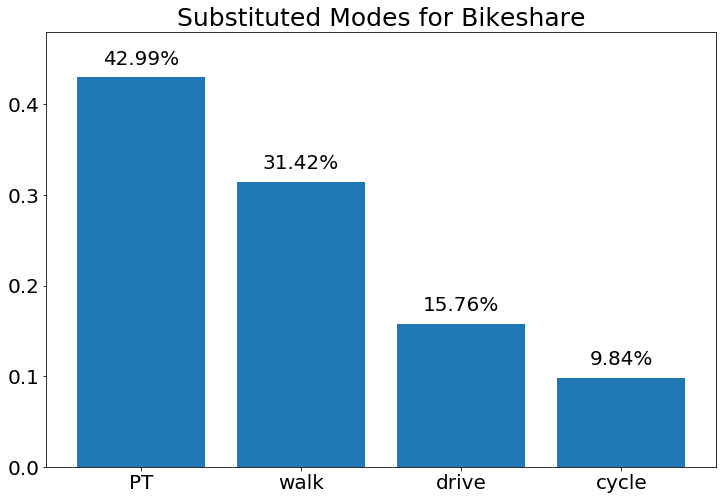

In [68]:
%matplotlib inline

# dissimilarity between share bike and public transport
dissimilarity = 0.5
nested_logit_experiment_overall(dissimilarity)